## Imports

In [2]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [4]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [5]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Ensemble Model

In [24]:
class FoodEnsemble(nn.Module):
    def __init__(self, resnet, densenet):
        super(FoodEnsemble, self).__init__()
        self.resnet = resnet
        self.densenet = densenet
        self.alpha = 0.5
    def forward(self, x):
        with torch.no_grad():
            a1 = self.resnet(x)
            a2 = self.densenet(x)
        return self.alpha * a1 + (1 - self.alpha) * a2
        

resnet = gpu(torch.load("../saved_models/food/res18/res18-unfreeze.dat"))
densenet = gpu(torch.load("../saved_models/food/densenet/densenet.dat"))
resnext = gpu(torch.load("../saved_models/food/resnext/resnext.dat"))
model = FoodEnsemble(resnet, resnext)

print(model)

FoodEnsemble(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
def check_accuracy(model):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x), gpu(y)                
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    print('Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        average_loss, num_correct, num_samples, 100 * acc))


In [26]:
%%time
check_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation Loss: 0.0149 Got 8817 / 11016 correct 80.04%
CPU times: user 2min 42s, sys: 48.6 s, total: 3min 31s
Wall time: 4min 26s


## Evaluation

In [27]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

Top 1 Accuracy of the network on the all test images: 79.85 %


In [28]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 94.87 %


In [29]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [30]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

In [31]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[237   5   0 ...   0   2   0]
 [  0 250   0 ...   0   0   0]
 [  0   0  55 ...   0   0   0]
 ...
 [  0   0   0 ...  90   1   0]
 [  0   0   0 ...   0  73   0]
 [  0   0   0 ...   0   0 158]]
237 307


<AxesSubplot:>

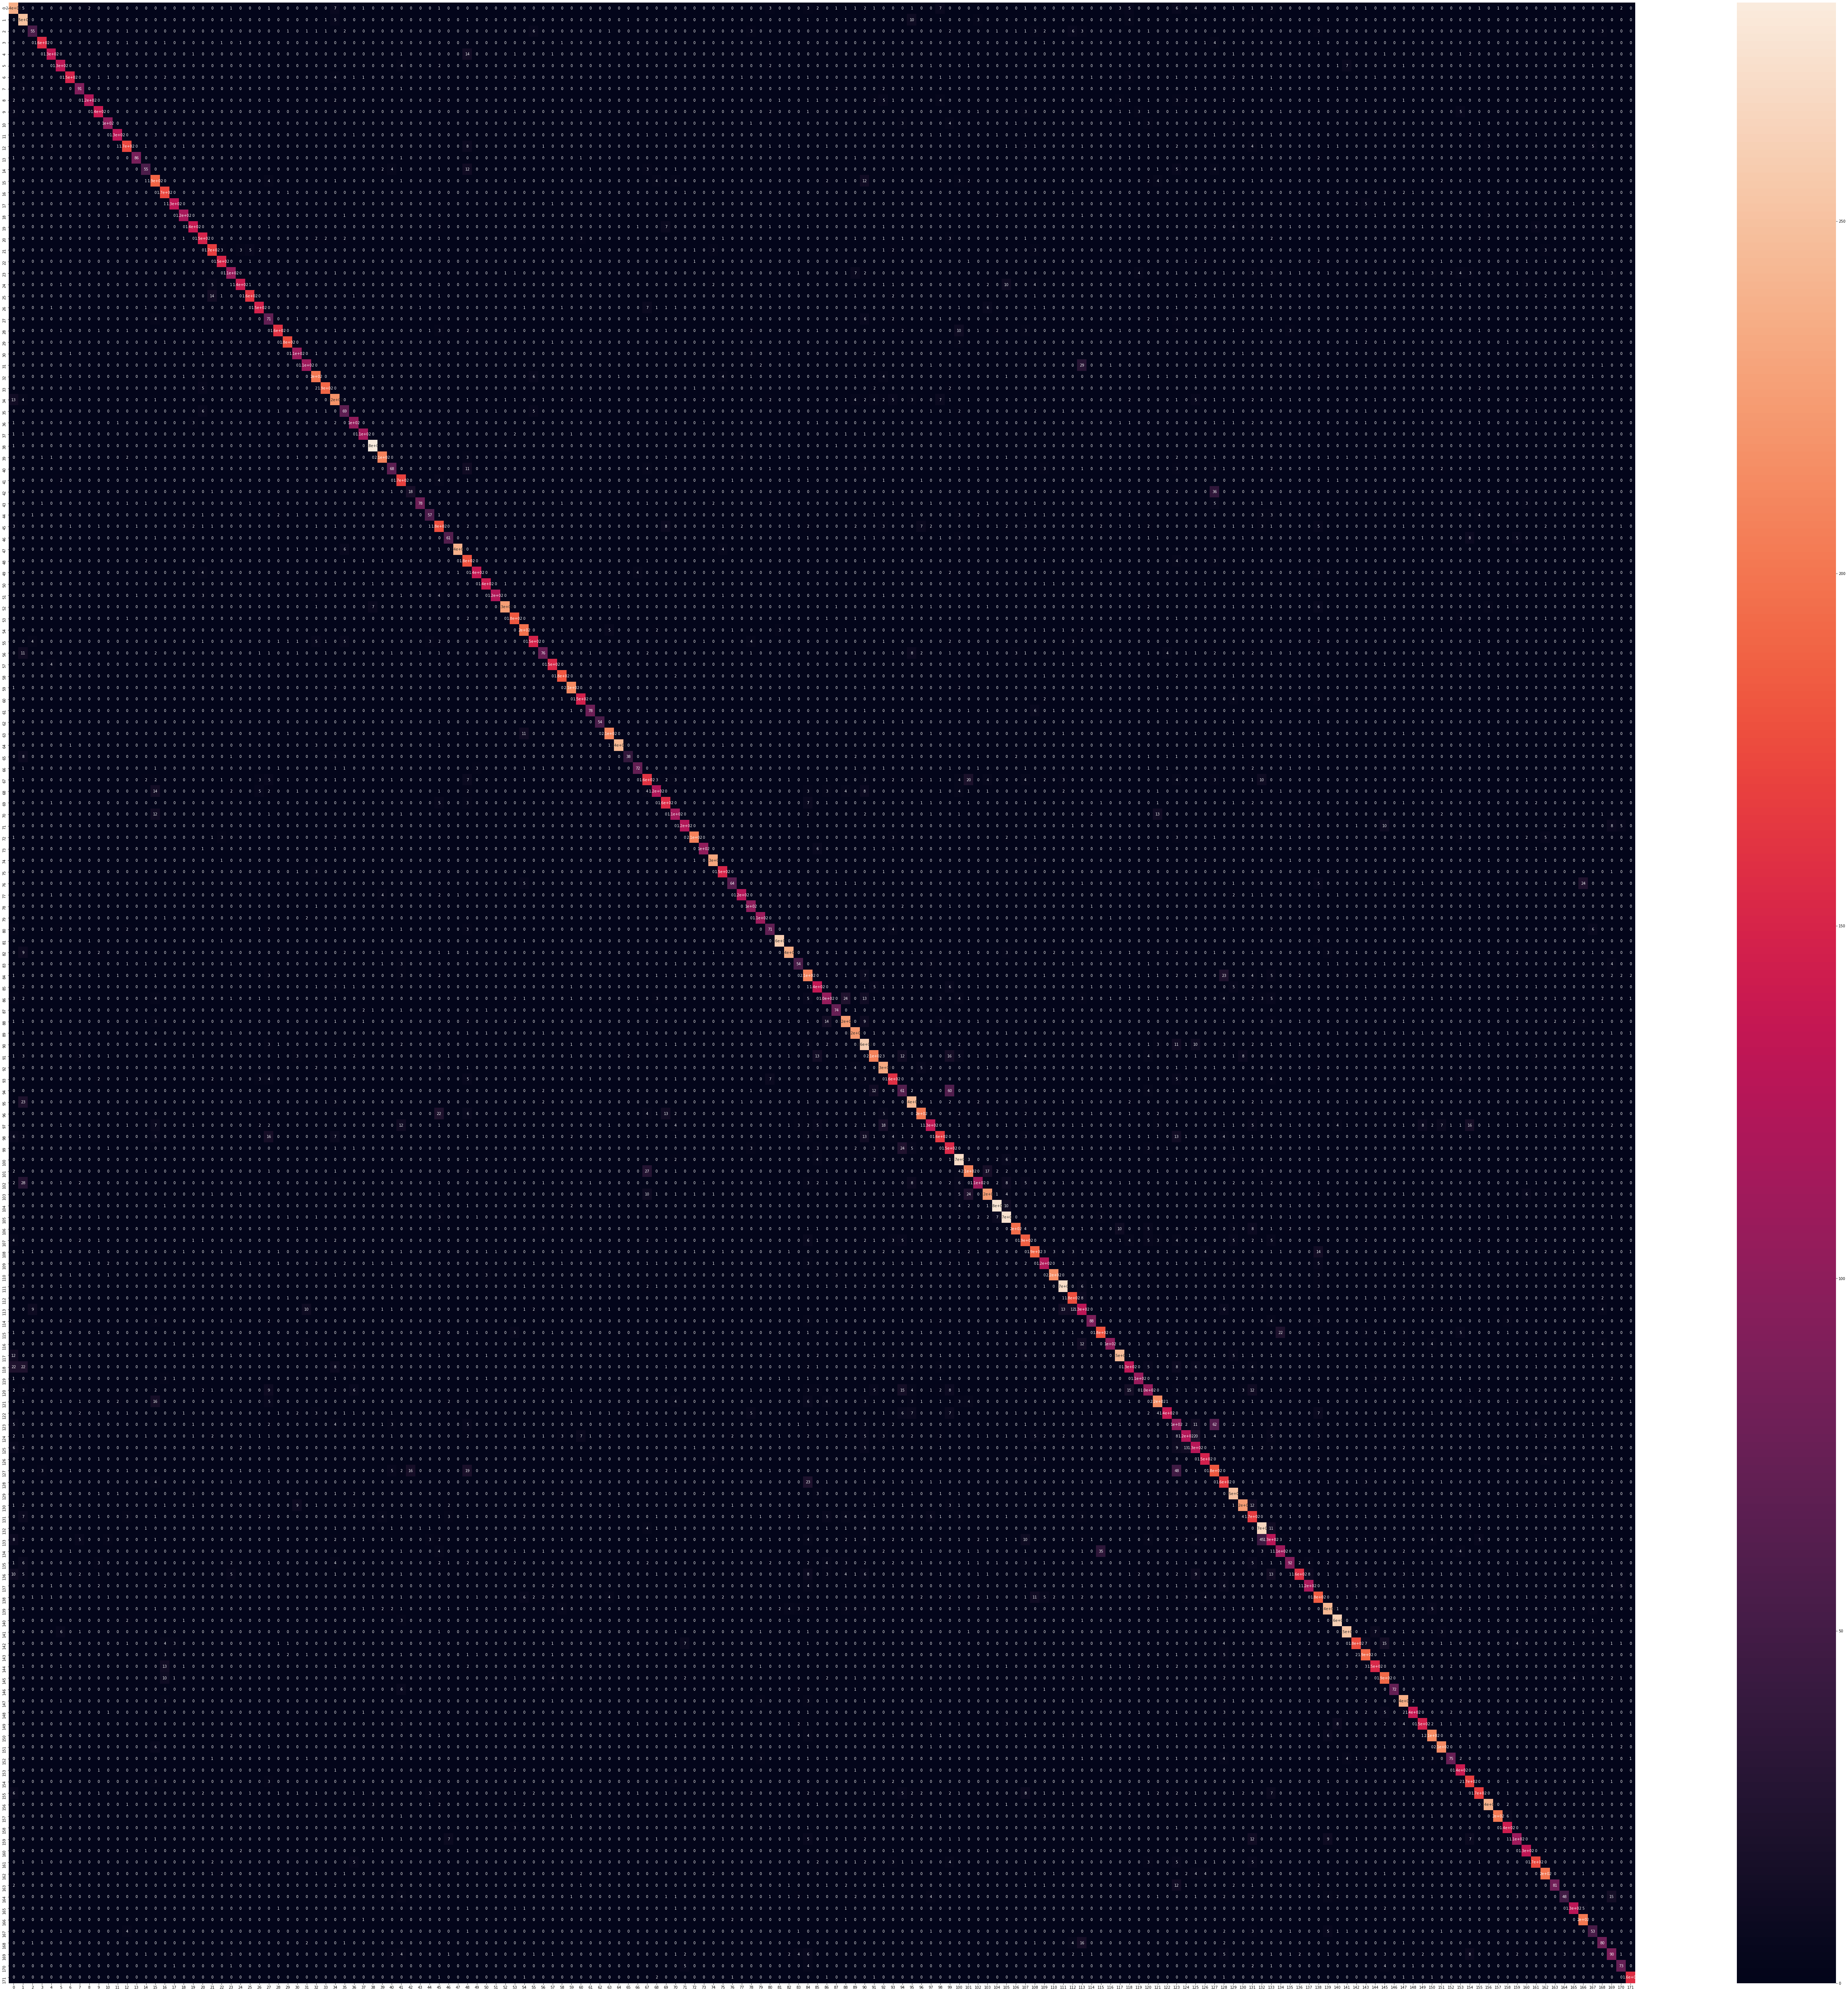

In [32]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

In [33]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
classes = train_dataset.classes
class_names = list(map(lambda x : food_names[int(x) - 1], classes))
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=class_names))


Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.81
Macro Recall: 0.79
Macro F1-score: 0.80

Weighted Precision: 0.81
Weighted Recall: 0.80
Weighted F1-score: 0.80

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.64      0.77      0.70       307
             Fried Sweet and Sour Tenderloin       0.60      0.87      0.71       287
                                   Fried egg       0.76      0.56      0.65        98
                         Noodles with Wonton       0.95      0.92      0.93       168
              Hot and Sour Fern Root Noodles       0.91      0.85      0.88       156
                                Sour cabbage       0.83      0.86      0.85       152
           Braised Intestines in Brown Sauce       0.94      0.84      0.88       178
                   Chinese Yam in Hot Toffee       0.79      0.88      0.

In [34]:
print(len(y_test))

33154


In [35]:
# Class 0 Statistics

TP = 0
FP = 0
FN = 0
for pred,label in zip(y_pred, y_test):
    if pred == 0 and label == 0:
        TP += 1
    if pred == 0 and label != 0:
        FP += 1
    if pred != 0 and label == 0:
        FN += 1
print("Class 0 ({}) Statistics".format(food_names[0]))
print("True Positives: {}".format(TP))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))
print("Precision: {}".format(TP / (TP + FP)))
print("Recall: {}".format(TP / (TP + FN)))

Class 0 (Braised Pork) Statistics
True Positives: 237
False Positives: 134
False Negatives: 70
Precision: 0.6388140161725068
Recall: 0.7719869706840391
